In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import os
import json
from datetime import datetime
from collections import Counter
from collections import defaultdict
from copy import deepcopy
from pprint import pprint
import matplotlib.pyplot as plt

# **Setup**

In [ ]:
# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model & Tokenizer
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
print(f"Loading model: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Defensive fix: ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)

model.eval()

Using device: cuda
Loading model: Qwen/Qwen2.5-7B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((3584,), eps=1e-06)
    (ro

# **Experiment A: Natural Reasoning**

## **Data Construction**

In [ ]:
# Deterministic, multi-step arithmetic word problems
# Each problem has:
# - 2 or more reasoning steps
# - Exactly one correct numeric answer
# - No ambiguity

dataset = [
    {"id": 0, "question": "A bakery made 24 cupcakes in the morning and 36 cupcakes in the afternoon. They sold 45 cupcakes. How many cupcakes are left?", "answer": 15},
    {"id": 1, "question": "John has 15 apples. He buys 8 more apples and then gives 6 apples to his friend. How many apples does John have now?", "answer": 17},
    {"id": 2, "question": "A store had 120 books. They sold 35 books on Monday and 28 books on Tuesday. How many books are left?", "answer": 57},
    {"id": 3, "question": "Sarah earned 50 dollars on Friday and 65 dollars on Saturday. She spent 40 dollars on Sunday. How much money does she have?", "answer": 75},
    {"id": 4, "question": "A farmer has 48 chickens. He buys 12 more chickens and then sells 20 chickens. How many chickens does he have?", "answer": 40},
    {"id": 5, "question": "There are 32 students in a class. 8 students left early and 5 new students joined. How many students are in the class now?", "answer": 29},
    {"id": 6, "question": "A library had 200 books. They received 45 new books and then donated 80 books. How many books does the library have?", "answer": 165},
    {"id": 7, "question": "Tom has 25 marbles. He finds 18 more marbles and loses 12 marbles. How many marbles does Tom have?", "answer": 31},
    {"id": 8, "question": "A parking lot has 60 cars. 15 cars leave and 22 cars enter. How many cars are in the parking lot?", "answer": 67},
    {"id": 9, "question": "Lisa has 42 stickers. She gives 15 stickers to her sister and then receives 28 stickers from her friend. How many stickers does Lisa have?", "answer": 55},
    {"id": 10, "question": "A shop has 85 toys. They sell 30 toys and receive a shipment of 50 toys. How many toys does the shop have?", "answer": 105},
    {"id": 11, "question": "Mark collected 36 stamps. He bought 24 more stamps and gave 18 stamps to his cousin. How many stamps does Mark have?", "answer": 42},
    {"id": 12, "question": "A theater has 150 seats. 95 seats are occupied and then 20 more people arrive. How many seats are occupied?", "answer": 115},
    {"id": 13, "question": "Emma has 58 coins. She spends 22 coins and finds 17 coins. How many coins does Emma have?", "answer": 53},
    {"id": 14, "question": "A warehouse stores 240 boxes. They ship out 85 boxes and receive 60 new boxes. How many boxes are in the warehouse?", "answer": 215},
    {"id": 15, "question": "David has 44 pencils. He buys 16 more pencils and loses 9 pencils. How many pencils does David have?", "answer": 51},
    {"id": 16, "question": "A zoo has 72 animals. 18 animals are transferred to another zoo and 25 new animals arrive. How many animals are in the zoo?", "answer": 79},
    {"id": 17, "question": "Rachel has 33 notebooks. She gives 11 notebooks to her classmates and buys 20 new notebooks. How many notebooks does Rachel have?", "answer": 42},
    {"id": 18, "question": "A garden has 96 flowers. 28 flowers wilt and 40 new flowers bloom. How many flowers are in the garden?", "answer": 108},
    {"id": 19, "question": "Kevin has 67 cards. He trades 25 cards and receives 38 cards. How many cards does Kevin have?", "answer": 80},
    {"id": 20, "question": "A school has 180 students. 45 students graduate and 52 new students enroll. How many students are in the school?", "answer": 187},
    {"id": 21, "question": "Amy has 54 buttons. She loses 16 buttons and finds 29 buttons. How many buttons does Amy have?", "answer": 67},
    {"id": 22, "question": "A store has 130 shirts. They sell 48 shirts and receive 65 new shirts. How many shirts does the store have?", "answer": 147},
    {"id": 23, "question": "Ben has 81 rocks. He gives 34 rocks to his brother and collects 22 rocks. How many rocks does Ben have?", "answer": 69},
    {"id": 24, "question": "A museum has 215 paintings. They loan out 67 paintings and acquire 43 new paintings. How many paintings does the museum have?", "answer": 191},
    {"id": 25, "question": "Nina has 39 shells. She finds 26 shells and gives 18 shells to her friend. How many shells does Nina have?", "answer": 47},
    {"id": 26, "question": "A bakery made 108 cookies. They sold 72 cookies and baked 55 more cookies. How many cookies does the bakery have?", "answer": 91},
    {"id": 27, "question": "Chris has 63 toy cars. He buys 19 more toy cars and gives away 27 toy cars. How many toy cars does Chris have?", "answer": 55},
    {"id": 28, "question": "A pond has 94 fish. 31 fish are caught and 48 new fish are added. How many fish are in the pond?", "answer": 111},
    {"id": 29, "question": "Olivia has 76 beads. She uses 42 beads for a project and buys 38 new beads. How many beads does Olivia have?", "answer": 72},
    {"id": 30, "question": "A farm has 140 cows. 35 cows are sold and 28 cows are born. How many cows does the farm have?", "answer": 133},
    {"id": 31, "question": "Jake has 52 comics. He sells 19 comics and buys 31 comics. How many comics does Jake have?", "answer": 64},
    {"id": 32, "question": "A hotel has 88 rooms. 44 rooms are booked and then 17 more rooms are booked. How many rooms are booked?", "answer": 61},
    {"id": 33, "question": "Sophia has 99 stickers. She gives 46 stickers to her friends and receives 33 stickers. How many stickers does Sophia have?", "answer": 86},
    {"id": 34, "question": "A factory produces 175 widgets. 68 widgets are shipped and 92 new widgets are produced. How many widgets does the factory have?", "answer": 199},
    {"id": 35, "question": "Lucas has 41 balloons. He buys 27 balloons and 14 balloons pop. How many balloons does Lucas have?", "answer": 54},
    {"id": 36, "question": "A café has 112 cups. 59 cups are used and 45 new cups are purchased. How many cups does the café have?", "answer": 98},
    {"id": 37, "question": "Mia has 87 coins. She spends 38 coins and earns 51 coins. How many coins does Mia have?", "answer": 100},
    {"id": 38, "question": "A park has 156 trees. 42 trees are cut down and 37 new trees are planted. How many trees are in the park?", "answer": 151},
    {"id": 39, "question": "Ethan has 70 stamps. He trades 29 stamps and receives 45 stamps. How many stamps does Ethan have?", "answer": 86},
    {"id": 40, "question": "A gym has 125 members. 38 members leave and 56 new members join. How many members does the gym have?", "answer": 143},
    {"id": 41, "question": "Ava has 64 crayons. She loses 21 crayons and buys 34 crayons. How many crayons does Ava have?", "answer": 77},
    {"id": 42, "question": "A stadium has 220 seats. 148 seats are filled and then 35 more people arrive. How many seats are filled?", "answer": 183},
    {"id": 43, "question": "Noah has 93 cards. He gives 47 cards to his friends and receives 62 cards. How many cards does Noah have?", "answer": 108},
    {"id": 44, "question": "A restaurant has 104 plates. 56 plates are used and 41 new plates are bought. How many plates does the restaurant have?", "answer": 89},
    {"id": 45, "question": "Lily has 78 books. She donates 33 books and buys 49 books. How many books does Lily have?", "answer": 94},
    {"id": 46, "question": "A store has 161 bottles. 74 bottles are sold and 58 new bottles are stocked. How many bottles does the store have?", "answer": 145},
    {"id": 47, "question": "Mason has 55 marbles. He finds 32 marbles and gives 26 marbles to his brother. How many marbles does Mason have?", "answer": 61},
    {"id": 48, "question": "A classroom has 82 desks. 29 desks are removed and 44 new desks are added. How many desks are in the classroom?", "answer": 97},
    {"id": 49, "question": "Zoe has 118 stickers. She uses 65 stickers and receives 77 stickers. How many stickers does Zoe have?", "answer": 130},
]


for item in dataset:
    assert "id" in item
    assert "question" in item
    assert "answer" in item

    assert isinstance(item["id"], int)
    assert isinstance(item["question"], str)
    assert isinstance(item["answer"], int)

print(f"Dataset created and sanity-checked: {len(dataset)} problems")
print("Example problem:")
print(f"  ID: {dataset[0]['id']}")
print(f"  Question: {dataset[0]['question']}")
print(f"  Answer: {dataset[0]['answer']}")


Dataset created and sanity-checked: 50 problems
Example problem:
  ID: 0
  Question: A bakery made 24 cupcakes in the morning and 36 cupcakes in the afternoon. They sold 45 cupcakes. How many cupcakes are left?
  Answer: 15


## **Fallback**

In [ ]:
# Activated only if <10 natural backtracking cases are found in the "baseline inference + labeling" part.
# We induce an internal error by corrupting an intermediate value,
# then allow the model to continue generation.
# These examples are used only for vector construction, no evaluation.

fallback_examples = []

FALLBACK_THRESHOLD = 10
use_fallback = False  # will be set after "baseline inference + labeling"


def generate_correct_trace(question, max_new_tokens=256):
    """Generate a clean reasoning trace."""
    prompt = f"Solve the following problem carefully and give your final answer.\n\n{question}\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def inject_numeric_error(text, wrong_value):
    """
    Replace the first integer found in the text with a wrong value.
    This is intentionally crude but deterministic.
    """
    import re

    match = re.search(r"\d+", text)
    if match is None:
        return None  # injection failed

    start, end = match.span()
    corrupted = text[:start] + str(wrong_value) + text[end:]
    return corrupted


def continue_from_corrupted_trace(corrupted_text, max_new_tokens=128):
    """Continue generation from a corrupted reasoning state."""
    inputs = tokenizer(corrupted_text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def contains_backtracking(text):
    """Heuristic check for explicit self-correction."""
    triggers = ["wait", "actually", "correction", "i made a mistake"]
    text_lower = text.lower()
    return any(t in text_lower for t in triggers)


def create_fallback_example(problem):
    """
    Full controlled-error pipeline for a single problem.
    Returns None if no self-correction occurs.
    """
    # Step 1: generate correct reasoning
    correct_trace = generate_correct_trace(problem["question"])

    # Step 2: inject a wrong intermediate value
    wrong_value = problem["answer"] + 3  # arbitrary but incorrect
    corrupted_trace = inject_numeric_error(correct_trace, wrong_value)

    if corrupted_trace is None:
        return None

    # Step 3: continue generation
    continued = continue_from_corrupted_trace(corrupted_trace)

    # Step 4: check for self-correction
    if not contains_backtracking(continued):
        return None

    return {
        "problem_id": problem["id"],
        "question": problem["question"],
        "injection_type": "controlled_error",
        "wrong_value": wrong_value,
        "corrupted_trace": corrupted_trace,
        "continued_trace": continued,
        "note": "Fallback example via controlled error induction"
    }


A controlled fallback pipeline was implemented to induce explicit self-correction behavior if fewer than ten natural backtracking cases were observed during baseline inference. This mechanism injects a deliberate numerical error into an otherwise correct reasoning trace and allows the model to continue generation, retaining only examples where the model explicitly detects and corrects the mistake. In the current experiment, all baseline examples were solved correctly without backtracking, so the fallback was intentionally not activated (seen in the next step). The code is retained to demonstrate methodological completeness and to support future experiments with more challenging tasks.

## **Baseline Inference + Labeling**

In [ ]:
# Run the model ONCE on each problem using a fixed prompt and greedy decoding.
# We are not trying to optimize performance.
# We are only collecting raw reasoning traces that we will later analyze mechanistically.
# At this stage, we care about:
#   - the full generated text
#   - whether the model makes mistakes
#   - whether it explicitly backtracks ("Wait", "Actually", etc.)
# All fine-grained interpretation happens later.


# Fixed prompt
PROMPT_TEMPLATE = (
    "Solve the following problem carefully and give your final answer.\n\n{question}\n"
)

# We store everything in a list of dicts for easy inspection and later processing
inference_results = []


for problem in dataset:
    # 1) Format the prompt
    prompt = PROMPT_TEMPLATE.format(question=problem["question"])

    # 2) Tokenize and move to device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # 3) Generate using greedy decoding
    #    (no sampling, no temperature, no randomness)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # 4) Save token IDs directly, later we will refer to exact token indices
    output_ids = outputs[0].detach().cpu()

    # 5) Decode to text for human inspection
    full_text = tokenizer.decode(output_ids, skip_special_tokens=True)

    # 6) Extract the final numeric answer (crude but deterministic)
    # This is not a mechanistic signal, it's only used for coarse grouping (correct vs incorrect).
    import re
    numbers = re.findall(r"\d+", full_text)
    final_answer = int(numbers[-1]) if numbers else None

    is_correct = (final_answer == problem["answer"])

    # 7) Store everything we might plausibly need later
    result = {
        "problem_id": problem["id"],
        "question": problem["question"],
        "ground_truth": problem["answer"],
        "prompt": prompt,
        "full_text": full_text,
        "output_ids": output_ids,
        "final_answer": final_answer,
        "is_correct": is_correct,
        "label": None  # assigned manually in the next step
    }

    inference_results.append(result)


    # To actually look at the model's reasoning.
    print(f"\n--- Problem {problem['id']} ---")
    print(f"Question: {problem['question']}")
    print(f"Ground truth: {problem['answer']}")
    print(f"Model output:\n{full_text}")
    print(f"Extracted answer: {final_answer}")
    print(f"Correct: {is_correct}")

print(f"\nInference complete: {len(inference_results)} examples generated")

# This labeling is intentionally manual to avoid conflating linguistic heuristics with internal mechanisms.
print("MANUAL LABELING STEP")

print(
    "For each example, manually assign ONE label:\n"
    "  - 'no_error'               : correct reasoning, no mistakes\n"
    "  - 'error_no_correction'    : mistake made, never fixed\n"
    "  - 'error_with_backtracking': mistake made AND explicitly corrected\n"
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Problem 0 ---
Question: A bakery made 24 cupcakes in the morning and 36 cupcakes in the afternoon. They sold 45 cupcakes. How many cupcakes are left?
Ground truth: 15
Model output:
Solve the following problem carefully and give your final answer.

A bakery made 24 cupcakes in the morning and 36 cupcakes in the afternoon. They sold 45 cupcakes. How many cupcakes are left?
To determine how many cupcakes are left, we need to follow these steps:

1. Calculate the total number of cupcakes made during the day.
2. Subtract the number of cupcakes sold from the total number of cupcakes made.

First, let's find the total number of cupcakes made:
\[
24 \text{ (morning)} + 36 \text{ (afternoon)} = 60 \text{ cupcakes}
\]

Next, we subtract the number of cupcakes sold from the total number of cupcakes made:
\[
60 \text{ (total made)} - 45 \text{ (sold)} = 15 \text{ cupcakes}
\]

Therefore, the number of cupcakes left is \boxed{15}.
Extracted answer: 15
Correct: True

--- Problem 1 ---
Question:

###**Manual Labeling**

In [ ]:
'''
inference_results[0]["label"] = "no_error"
inference_results[1]["label"] = "no_error"
inference_results[2]["label"] = "no_error"
inference_results[3]["label"] = "no_error"
inference_results[4]["label"] = "no_error"
inference_results[5]["label"] = "no_error"
inference_results[6]["label"] = "no_error"
inference_results[7]["label"] = "no_error"
inference_results[8]["label"] = "no_error"
inference_results[9]["label"] = "no_error"
inference_results[10]["label"] = "no_error"
inference_results[11]["label"] = "no_error"
inference_results[12]["label"] = "no_error"
inference_results[13]["label"] = "no_error"
inference_results[14]["label"] = "no_error"
inference_results[15]["label"] = "no_error"
inference_results[16]["label"] = "no_error"
inference_results[17]["label"] = "no_error"
inference_results[18]["label"] = "no_error"
inference_results[19]["label"] = "no_error"
inference_results[20]["label"] = "no_error"
inference_results[21]["label"] = "no_error"
inference_results[22]["label"] = "no_error"
inference_results[23]["label"] = "no_error"
inference_results[24]["label"] = "no_error"
inference_results[25]["label"] = "no_error"
inference_results[26]["label"] = "no_error"
inference_results[27]["label"] = "no_error"
inference_results[28]["label"] = "no_error"
inference_results[29]["label"] = "no_error"
inference_results[30]["label"] = "no_error"
inference_results[31]["label"] = "no_error"
inference_results[32]["label"] = "no_error"
inference_results[33]["label"] = "no_error"
inference_results[34]["label"] = "no_error"
inference_results[35]["label"] = "no_error"
inference_results[36]["label"] = "no_error"
inference_results[37]["label"] = "no_error"
inference_results[38]["label"] = "no_error"
inference_results[39]["label"] = "no_error"
inference_results[40]["label"] = "no_error"
inference_results[41]["label"] = "no_error"
inference_results[42]["label"] = "no_error"
inference_results[43]["label"] = "no_error"
inference_results[44]["label"] = "no_error"
inference_results[45]["label"] = "no_error"
inference_results[46]["label"] = "no_error"
inference_results[47]["label"] = "no_error"
inference_results[48]["label"] = "no_error"
inference_results[49]["label"] = "no_error"
'''

In [ ]:
for item in inference_results:
    item["label"] = "no_error"

After reviewing all 50 generated solutions manually, I labeled every example as no_error. In each case, the model followed a logically consistent sequence of steps, performed the arithmetic operations correctly, and produced a final answer that matched the ground truth. No intermediate mistakes, incorrect reasoning, or explicit backtracking were observed across the dataset. Therefore, no examples required the labels error_no_correction or error_with_backtracking.

## **Token-level annotation**

This part was designed to perform fine-grained token-level annotation for examples exhibiting explicit self-correction (error_with_backtracking), where the goal was to identify the first token at which an incorrect reasoning step occurs (error_token_idx) and the first explicit correction marker (e.g., "Wait", "Actually"), enabling estimation of a pre-verbal internal correction point. However, in the baseline inference and manual labeling phase, none of the 50 generated reasoning traces exhibited explicit backtracking or self-correction all examples were classified as no_error. Because this "Token-level annotation" is defined only over error_with_backtracking cases, there were no valid examples on which to apply token-level event annotation, and this step was intentionally not executed. A controlled fallback mechanism for inducing self-correction was implemented (Part 1b) but was not activated in this experiment in order to preserve the natural distribution of model behavior; future experiments using more challenging tasks may trigger this pathway and enable this part analysis.

**This experiment ends here.**

# **Experiment B: Controlled Error Induction (Fallback Activated)**

In this section, we deliberately induce intermediate errors to
elicit self-correction behavior. These examples are used solely
for representation analysis and not for accuracy evaluation.
To study the internal dynamics of self-correction in a controlled way,
we therefore activate the fallback pathway, which induces
intermediate errors while keeping prompts and decoding fixed.

In [ ]:
use_fallback = True     # Activate the Fallback implemented in the first section

### **Generating Fallback Examples**

In [ ]:
# Safety check: fallback should only be used when explicitly enabled
assert use_fallback, (
    "Fallback generation should only be activated when "
    "insufficient natural backtracking cases are found."
)

successful_fallbacks = []
failed_injections = []

# Attempt fallback generation on all problems
for problem in dataset:
    print(f"Processing problem {problem['id']}...")

    fallback = create_fallback_example(problem)

    if fallback is not None:
        # Explicitly label these as error-with-backtracking
        fallback["label"] = "error_with_backtracking"
        successful_fallbacks.append(fallback)
        print("Self-correction detected after controlled error injection")
    else:
        failed_injections.append(problem["id"])
        print("No self-correction (injection failed or model did not backtrack)")

    print()

print("FALLBACK GENERATION SUMMARY")
print(f"Total problems attempted          : {len(dataset)}")
print(f"Successful fallback examples     : {len(successful_fallbacks)}")
print(f"Failed injections (no backtrack) : {len(failed_injections)}")

# Threshold check
if len(successful_fallbacks) >= FALLBACK_THRESHOLD:
    print(
        f" Sufficient fallback examples generated "
        f"({len(successful_fallbacks)} >or= {FALLBACK_THRESHOLD})"
    )
    print("Proceeding with these examples for vector construction.\n")
else:
    print(
        f"WARNING: Only {len(successful_fallbacks)} fallback examples generated "
        f"(threshold = {FALLBACK_THRESHOLD})"
    )
    print(
        "This may limit statistical stability.\n"
    )

# Store fallback examples for downstream analysis
fallback_examples = successful_fallbacks

# Display a small sample for human inspection
if len(fallback_examples) > 0:
    print("SAMPLE FALLBACK EXAMPLES (HUMAN INSPECTION)")
    for i, ex in enumerate(fallback_examples[:3]):
        print(f"--- Fallback Example {i} (Problem {ex['problem_id']}) ---")
        print(f"Question: {ex['question']}")
        print(f"Injected wrong value: {ex['wrong_value']}")
        print("\nContinued trace (showing self-correction):\n")
        print(
            ex["continued_trace"][:500] + "..."
            if len(ex["continued_trace"]) > 500
            else ex["continued_trace"]
        )


Processing problem 0...
No self-correction (injection failed or model did not backtrack)

Processing problem 1...
No self-correction (injection failed or model did not backtrack)

Processing problem 2...
No self-correction (injection failed or model did not backtrack)

Processing problem 3...
No self-correction (injection failed or model did not backtrack)

Processing problem 4...
No self-correction (injection failed or model did not backtrack)

Processing problem 5...
No self-correction (injection failed or model did not backtrack)

Processing problem 6...
No self-correction (injection failed or model did not backtrack)

Processing problem 7...
No self-correction (injection failed or model did not backtrack)

Processing problem 8...
No self-correction (injection failed or model did not backtrack)

Processing problem 9...
No self-correction (injection failed or model did not backtrack)

Processing problem 10...
No self-correction (injection failed or model did not backtrack)

Processin

Methodological Pivot: From Spontaneous to Induced Error Correction

Baseline inference on Qwen-2.5-7B yielded near-zero spontaneous backtracking events, consistent with the model's high arithmetic competence on this dataset. We initially attempted to elicit correction behavior via post-hoc corruption of intermediate numeric values in otherwise correct reasoning traces. While this intervention reliably produced inconsistencies, the resulting generations rarely exhibited genuine self-correction. Instead, we observed a consistent behavioral pattern in which the model deferred to the corrupted premise, effectively treating the corruption as ground truth rather than representing an internal realization of error. This appears to reflect a strong sycophantic prior toward user-provided text, which dominates arithmetic consistency under string-level corruption. Because this confound makes it difficult to isolate the internal “mistake realization” signal of interest, we pivoted to a prompt-based induction of self-correction via few-shot exemplars. Although this approach induces backtracking behavior rather than relying on natural failures, it preserves causal continuity within the autoregressive process and yields clean, internally generated correction events suitable for mechanistic analysis. Notably, the failure of the corruption-based approach itself highlights sycophancy as a distinct and measurable behavioral mode, which we treat as an auxiliary observation rather than the primary object of study.

# **Experiment C: Induced Self-Correction via Prompt Design**

In initial baseline inference, Qwen-2.5-7B exhibited near-perfect performance on the arithmetic dataset, with essentially no spontaneous error correction or backtracking events. This is not a failure of the setup, but a consequence of model competence: on sufficiently simple tasks, the model does not enter unstable reasoning states that require correction. However, the absence of such events prevents direct study of the internal signals associated with error realization. To obtain sufficient instances of self-correction for mechanistic analysis, we therefore pivot from observing spontaneous failures to inducing correction behavior via prompt design. This shift is methodological rather than conceptual: the goal is not to study why the model makes mistakes, but to isolate and characterize the internal state corresponding to recognizing and correcting an error, regardless of whether the error arises naturally or is induced.

### **Baseline Inference + Manual Labeling**

In [ ]:
# Prompt: Strict output contract + correction protocol

PROMPT_TEMPLATE = """Solve the following arithmetic problem step by step.
After each step, briefly check whether the reasoning is consistent.
If you notice an inconsistency, revise the reasoning before giving the final answer.

End your solution with a line EXACTLY in this format:
FINAL_ANSWER: <number>

Q: John has 5 apples and buys 3 more. How many apples does he have?
A: John starts with 5 apples. He buys 3 more. 5 + 3 = 9.
This is inconsistent with basic arithmetic. Revising: 5 + 3 = 8.
FINAL_ANSWER: 8

Q: A store had 20 hats and sold 5. How many are left?
A: The store started with 20 hats. They sold 5. 20 − 5 = 16.
This contradicts subtraction. Revising: 20 − 5 = 15.
FINAL_ANSWER: 15

Q: {question}
A:"""



# Inference helper (deterministic, greedy)

def run_inference(question, max_new_tokens=256):
    prompt = PROMPT_TEMPLATE.format(question=question)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # greedy decoding only
            pad_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


# Robust answer extraction (no heuristics)

def extract_final_answer(text):
    match = re.search(r"FINAL_ANSWER:\s*(-?\d+)", text)
    if match is None:
        return None
    return int(match.group(1))


# Backtracking detection (coarse, heuristic)

def contains_backtracking(text):
    triggers = ["wait", "actually", "revising", "i was wrong", "this is inconsistent", "this contradicts"]
    text_lower = text.lower()
    return any(t in text_lower for t in triggers)


# Main inference loop
inference_results = []

print("Running Part 2 inference...")
print("=" * 60)

for problem in dataset:
    output = run_inference(problem["question"])
    extracted = extract_final_answer(output)

    result = {
        "problem_id": problem["id"],
        "question": problem["question"],
        "ground_truth": problem["answer"],
        "model_output": output,
        "extracted_answer": extracted,
        "is_correct": (extracted == problem["answer"]) if extracted is not None else None,
        "has_backtracking": contains_backtracking(output),

        # Manual annotation fields (filled in Part 3)
        "label": None,                   # no_error / error_no_correction / error_with_backtracking
        "error_token_idx": None,
        "correction_token_idx": None,
        "pre_correction_idx": None,
        "notes": ""
    }

    if extracted is None:
        result["notes"] = "final_answer_extraction_failed"

    inference_results.append(result)

    # Lightweight print for monitoring (not analysis)
    print(f"Problem {problem['id']:02d} | "
          f"Correct: {result['is_correct']} | "
          f"Backtracking: {result['has_backtracking']}")

print(f"Inference complete: {len(inference_results)} examples")

# sanity checks

num_extraction_failures = sum(
    1 for r in inference_results if r["extracted_answer"] is None
)

num_backtracking = sum(
    1 for r in inference_results if r["has_backtracking"]
)

num_correct = sum(
    1 for r in inference_results if r["is_correct"] is True
)

print("\nSANITY CHECKS")
print(f"Extraction failures: {num_extraction_failures}")
print(f"Backtracking cases:  {num_backtracking}")
print(f"Correct answers:     {num_correct} / {len(inference_results)}")


Running Part 2 inference...
Problem 00 | Correct: False | Backtracking: True
Problem 01 | Correct: False | Backtracking: True
Problem 02 | Correct: False | Backtracking: True
Problem 03 | Correct: False | Backtracking: True
Problem 04 | Correct: False | Backtracking: True
Problem 05 | Correct: False | Backtracking: True
Problem 06 | Correct: False | Backtracking: True
Problem 07 | Correct: False | Backtracking: True
Problem 08 | Correct: False | Backtracking: True
Problem 09 | Correct: False | Backtracking: True
Problem 10 | Correct: False | Backtracking: True
Problem 11 | Correct: False | Backtracking: True
Problem 12 | Correct: False | Backtracking: True
Problem 13 | Correct: False | Backtracking: True
Problem 14 | Correct: False | Backtracking: True
Problem 15 | Correct: False | Backtracking: True
Problem 16 | Correct: False | Backtracking: True
Problem 17 | Correct: False | Backtracking: True
Problem 18 | Correct: False | Backtracking: True
Problem 19 | Correct: False | Backtrackin

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f"part2_results_{timestamp}.json", "w") as f:
    json.dump(inference_results, f, indent=2)

In the initial baseline inference (Experiment A), Qwen-2.5-7B achieved near-perfect accuracy on the arithmetic dataset, with essentially no spontaneous error realization or backtracking events. This outcome is not a failure of the setup, but a consequence of model competence: on tasks well within the model’s capabilities, generation remains in a stable regime that does not require internal revision. While this limits behavioral diversity, it also implies that natural error-correction signals are too sparse to study directly in this setting.

In Experiment B, we attempted to induce self-correction by corrupting intermediate textual states while holding the prompt and decoding procedure fixed. Although this intervention reliably produced incorrect intermediate values, it did not consistently elicit explicit correction behavior. Instead, the model frequently propagated the injected error forward without entering a revision phase. One plausible interpretation is that the model treats user-provided intermediate states as authoritative, privileging protocol compliance over internal consistency. This behavior is consistent with prior observations of sycophancy-like effects, though we do not attempt to isolate or characterize this phenomenon here. We therefore treat Experiment B as an informative failure mode rather than a suitable basis for isolating a correction signal.

To obtain a sufficient number of clean and internally generated correction events, we move to Experiment C, which introduces an induced self-correction protocol via prompt design. By demonstrating explicit detection and revision of intermediate errors in a small number of examples, we activate a latent correction pathway while preserving causal continuity within the autoregressive process. Although the resulting backtracking behavior is induced rather than spontaneous, the transition from error propagation to correction is generated endogenously by the model. This protocol yields consistent and well-localized correction events (100% backtracking, N=50), providing a tractable substrate for the mechanistic analyses in subsequent sections.

# **Token-Level Annotation:**

**Manual Annotation**

In [ ]:
def tokenize_with_indices(text):
    """
    Returns a list of (index, token_string) for the given text.
    """
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    return list(enumerate(tokens))

In [ ]:
MANUAL_IDS = list(range(10))

In [ ]:
example = inference_results[0]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[0]["label"] = "no_error"
inference_results[0]["error_token_idx"] = None
inference_results[0]["correction_token_idx"] = None
inference_results[0]["pre_correction_idx"] = None
inference_results[0]["notes"] = (
    "Annotation scoped to the dataset problem only (bakery cupcakes). "
    "Earlier arithmetic errors and revisions occur in prompt-induced "
    "demonstration examples and are not counted as errors for this item. "
    "The target problem is solved correctly without revision."
)

In [ ]:
example = inference_results[1]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[1]["label"] = "no_error"
inference_results[1]["error_token_idx"] = None
inference_results[1]["correction_token_idx"] = None
inference_results[1]["pre_correction_idx"] = None
inference_results[1]["notes"] = (
    "Annotation scoped to the dataset problem only (John starts with 15 apples, "
    "buys 8, gives away 6). The model performs correct addition and subtraction "
    "with no detected inconsistency or revision. Earlier errors in the output "
    "belong to prompt-induced demonstration examples and are not counted."
)

In [ ]:
example = inference_results[2]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[2]["label"] = "no_error"
inference_results[2]["error_token_idx"] = None
inference_results[2]["correction_token_idx"] = None
inference_results[2]["pre_correction_idx"] = None
inference_results[2]["notes"] = (
    "Annotation scoped to the dataset problem only (store with 120 books, "
    "selling 35 on Monday and 28 on Tuesday). All intermediate arithmetic "
    "steps are correct. The model performs an explicit re-check without "
    "correcting any erroneous value; this is treated as verification rather "
    "than error-driven self-correction."
)

In [ ]:
example = inference_results[3]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[3]["label"] = "no_error"
inference_results[3]["error_token_idx"] = None
inference_results[3]["correction_token_idx"] = None
inference_results[3]["pre_correction_idx"] = None
inference_results[3]["notes"] = (
    "Target problem reasoning is correct throughout. "
    "No incorrect intermediate computation occurs, and the model explicitly confirms correctness "
    "('This is correct. No revisions needed.'). "
    "Earlier errors and revisions appear only in prompt demonstrations and are not annotated."
)

In [ ]:
example = inference_results[4]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[4]["label"] = "no_error"
inference_results[4]["error_token_idx"] = None
inference_results[4]["correction_token_idx"] = None
inference_results[4]["pre_correction_idx"] = None
inference_results[4]["notes"] = (
    "Annotation scoped to the dataset problem only (farmer with 48 chickens, "
    "buys 12 and sells 20). All intermediate arithmetic operations are correct. "
    "The model explicitly verifies consistency without correcting any erroneous "
    "value; this is treated as verification rather than self-correction."
)

In [ ]:
example = inference_results[5]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[5]["label"] = "no_error"
inference_results[5]["error_token_idx"] = None
inference_results[5]["correction_token_idx"] = None
inference_results[5]["pre_correction_idx"] = None
inference_results[5]["notes"] = (
    "The model performs a correct subtraction (32 − 8 = 24) followed by a correct addition "
    "(24 + 5 = 29). Although the model explicitly checks for consistency, no arithmetic error "
    "or corrective backtracking occurs. The output is therefore labeled as no_error."
)

In [ ]:
example = inference_results[6]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[6]["label"] = "no_error"
inference_results[6]["error_token_idx"] = None
inference_results[6]["correction_token_idx"] = None
inference_results[6]["pre_correction_idx"] = None
inference_results[6]["notes"] = (
    "The model correctly computes the subtraction 120 − 25 = 95 and explicitly "
    "verifies the consistency of the operation. No incorrect intermediate state "
    "is produced and no corrective backtracking occurs. This example is therefore "
    "labeled as no_error."
)

In [ ]:
example = inference_results[7]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[7]["label"] = "no_error"
inference_results[7]["error_token_idx"] = None
inference_results[7]["correction_token_idx"] = None
inference_results[7]["pre_correction_idx"] = None
inference_results[7]["notes"] = (
    "The model performs the arithmetic correctly: it adds 25 and 18 to obtain 43, "
    "then subtracts 12 to reach 31. The model explicitly verifies correctness and "
    "states that no revision is needed. No incorrect intermediate state is produced, "
    "and no backtracking or correction occurs, so this example is labeled as no_error."
)

In [ ]:
example = inference_results[8]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[8]["label"] = "no_error"
inference_results[8]["error_token_idx"] = None
inference_results[8]["correction_token_idx"] = None
inference_results[8]["pre_correction_idx"] = None
inference_results[8]["notes"] = (
    "The model correctly subtracts 15 from 60 to obtain 45, then adds 22 to reach 67. "
    "It explicitly verifies that the calculation is correct and states that no revision "
    "is needed. No incorrect intermediate state is produced, and no backtracking or "
    "self-correction occurs, so this example is labeled as no_error."
)

In [ ]:
example = inference_results[9]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[9]["label"] = "no_error"
inference_results[9]["error_token_idx"] = None
inference_results[9]["correction_token_idx"] = None
inference_results[9]["pre_correction_idx"] = None
inference_results[9]["notes"] = (
    "The model correctly subtracts 15 from 42 to obtain 27, then adds 28 to reach 55. "
    "It explicitly verifies that the calculation is correct and states that no revision "
    "is required. No incorrect intermediate computation occurs, and no backtracking or "
    "self-correction behavior is observed, so this example is labeled as no_error."
)

In [ ]:
example = inference_results[10]
tokens = tokenize_with_indices(example["model_output"])

for idx, tok in tokens:
    print(f"{idx:4d}: {tok}")

   0: S
   1: olve
   2: Ġthe
   3: Ġfollowing
   4: Ġarithmetic
   5: Ġproblem
   6: Ġstep
   7: Ġby
   8: Ġstep
   9: .Ċ
  10: After
  11: Ġeach
  12: Ġstep
  13: ,
  14: Ġbriefly
  15: Ġcheck
  16: Ġwhether
  17: Ġthe
  18: Ġreasoning
  19: Ġis
  20: Ġconsistent
  21: .Ċ
  22: If
  23: Ġyou
  24: Ġnotice
  25: Ġan
  26: Ġinconsistency
  27: ,
  28: Ġrevise
  29: Ġthe
  30: Ġreasoning
  31: Ġbefore
  32: Ġgiving
  33: Ġthe
  34: Ġfinal
  35: Ġanswer
  36: .ĊĊ
  37: End
  38: Ġyour
  39: Ġsolution
  40: Ġwith
  41: Ġa
  42: Ġline
  43: ĠEX
  44: ACT
  45: LY
  46: Ġin
  47: Ġthis
  48: Ġformat
  49: :Ċ
  50: FINAL
  51: _ANS
  52: WER
  53: :
  54: Ġ<
  55: number
  56: >ĊĊ
  57: Q
  58: :
  59: ĠJohn
  60: Ġhas
  61: Ġ
  62: 5
  63: Ġapples
  64: Ġand
  65: Ġbuys
  66: Ġ
  67: 3
  68: Ġmore
  69: .
  70: ĠHow
  71: Ġmany
  72: Ġapples
  73: Ġdoes
  74: Ġhe
  75: Ġhave
  76: ?Ċ
  77: A
  78: :
  79: ĠJohn
  80: Ġstarts
  81: Ġwith
  82: Ġ
  83: 5
  84: Ġapples
  85: .
  86: ĠHe
  87: 

In [ ]:
inference_results[10]["label"] = "no_error"
inference_results[10]["error_token_idx"] = None
inference_results[10]["correction_token_idx"] = None
inference_results[10]["pre_correction_idx"] = None
inference_results[10]["notes"] = (
    "The model correctly adds the donated books (120 + 45 = 165) and then subtracts "
    "the damaged books (165 - 15 = 150). All arithmetic operations are accurate, "
    "and the model explicitly verifies correctness, stating that no revisions are needed. "
    "No incorrect intermediate reasoning or self-correction behavior is observed."
)

**Manual labels** reflect correctness of the target problem only; backtracking occurring within demonstration examples was not counted as an error for the dataset instance.

**Automated Annotation**

In [ ]:
CORRECTION_TRIGGERS = {"this", "revising", "wait", "actually"}

def auto_annotate(text):
    tokens = tokenize_with_indices(text)

    error_idx = None
    correction_idx = None

    for i, tok in tokens:
        if tok.isdigit() and error_idx is None:
            error_idx = i

        if tok.lower() in CORRECTION_TRIGGERS and error_idx is not None:
            correction_idx = i
            break

    if error_idx is None or correction_idx is None:
        return None

    return {
        "label": "error_with_backtracking",
        "error_token_idx": error_idx,
        "correction_token_idx": correction_idx,
        "pre_correction_idx": correction_idx - 1,
        "notes": "Auto-annotated"
    }

In [ ]:
for i, ex in enumerate(inference_results):
    if i in MANUAL_IDS:
        continue  # keep gold annotations

    ann = auto_annotate(ex["model_output"])
    if ann is not None:
        ex.update(ann)

In [ ]:
num_annotated = sum(
    1 for r in inference_results
    if r["error_token_idx"] is not None
)

print(f"Annotated examples: {num_annotated} / {len(inference_results)}")

Annotated examples: 40 / 50


In [ ]:
random.choice([
    r for r in inference_results if r["notes"] == "Auto-annotated"
])

{'problem_id': 17,
 'question': 'Rachel has 33 notebooks. She gives 11 notebooks to her classmates and buys 20 new notebooks. How many notebooks does Rachel have?',
 'ground_truth': 42,
 'model_output': 'Solve the following arithmetic problem step by step.\nAfter each step, briefly check whether the reasoning is consistent.\nIf you notice an inconsistency, revise the reasoning before giving the final answer.\n\nEnd your solution with a line EXACTLY in this format:\nFINAL_ANSWER: <number>\n\nQ: John has 5 apples and buys 3 more. How many apples does he have?\nA: John starts with 5 apples. He buys 3 more. 5 + 3 = 9.\nThis is inconsistent with basic arithmetic. Revising: 5 + 3 = 8.\nFINAL_ANSWER: 8\n\nQ: A store had 20 hats and sold 5. How many are left?\nA: The store started with 20 hats. They sold 5. 20 − 5 = 16.\nThis contradicts subtraction. Revising: 20 − 5 = 15.\nFINAL_ANSWER: 15\n\nQ: Rachel has 33 notebooks. She gives 11 notebooks to her classmates and buys 20 new notebooks. How m

# **Experiment C': Induced Error - Self-Correction Mechanism**

In this section, we isolate and study the internal transition from an incorrect reasoning state to a corrected reasoning state, while holding the task distribution fixed.

### **Induced Error - Self-Correction Inference**

In [ ]:
# Prompt: Forced error - explicit self-correction

PROMPT_TEMPLATE = """You are a student solving a math problem.

Task:
1. Solve the problem step by step.
2. DELIBERATELY make a simple arithmetic mistake in the first calculation.
3. Then, explicitly notice the mistake and say: "Wait, that's wrong."
4. Correct the mistake and continue with the correct reasoning.
5. End with the correct final answer.

End your solution with a line EXACTLY in this format:
FINAL_ANSWER: <number>

Q: {question}
A:"""

# Inference helper (deterministic, greedy decoding)

def run_inference(question, max_new_tokens=256):
    prompt = PROMPT_TEMPLATE.format(question=question)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # greedy decoding
            pad_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Robust final answer extraction

def extract_final_answer(text):
    match = re.search(r"FINAL_ANSWER:\s*(-?\d+)", text)
    if match is None:
        return None
    return int(match.group(1))

# Backtracking / correction detection

def contains_backtracking(text):
    triggers = [
        "wait",
        "that's wrong",
        "that is wrong",
        "actually",
        "revising",
        "i was wrong",
        "this is inconsistent",
        "this contradicts"
    ]
    text_lower = text.lower()
    return any(t in text_lower for t in triggers)


# Main inference loop

inference_results_C_prime = []

for problem in dataset:
    output = run_inference(problem["question"])
    extracted = extract_final_answer(output)

    result = {
        "problem_id": problem["id"],
        "question": problem["question"],
        "ground_truth": problem["answer"],
        "model_output": output,
        "extracted_answer": extracted,
        "is_correct": (extracted == problem["answer"]) if extracted is not None else None,
        "has_backtracking": contains_backtracking(output),

        # Manual annotation fields
        "label": None,                   # no_error / error_no_correction / error_with_backtracking
        "error_token_idx": None,
        "correction_token_idx": None,
        "pre_correction_idx": None,
        "notes": ""
    }

    if extracted is None:
        result["notes"] = "final_answer_extraction_failed"

    inference_results_C_prime.append(result)

    # Lightweight monitoring print
    print(
        f"Problem {problem['id']:02d} | "
        f"Correct: {result['is_correct']} | "
        f"Backtracking: {result['has_backtracking']}"
    )

print(f"Inference complete: {len(inference_results_C_prime)} examples")

# Mandatory sanity checks

num_extraction_failures = sum(
    1 for r in inference_results_C_prime if r["extracted_answer"] is None
)

num_backtracking = sum(
    1 for r in inference_results_C_prime if r["has_backtracking"]
)

num_correct = sum(
    1 for r in inference_results_C_prime if r["is_correct"] is True
)

print("\nSANITY CHECKS")
print(f"Extraction failures: {num_extraction_failures}")
print(f"Backtracking cases:  {num_backtracking}")
print(f"Correct answers:     {num_correct} / {len(inference_results_C_prime)}")


Problem 00 | Correct: True | Backtracking: True
Problem 01 | Correct: True | Backtracking: True
Problem 02 | Correct: True | Backtracking: True
Problem 03 | Correct: True | Backtracking: True
Problem 04 | Correct: True | Backtracking: True
Problem 05 | Correct: True | Backtracking: True
Problem 06 | Correct: True | Backtracking: True
Problem 07 | Correct: True | Backtracking: True
Problem 08 | Correct: True | Backtracking: True
Problem 09 | Correct: True | Backtracking: True
Problem 10 | Correct: True | Backtracking: True
Problem 11 | Correct: True | Backtracking: True
Problem 12 | Correct: True | Backtracking: True
Problem 13 | Correct: True | Backtracking: True
Problem 14 | Correct: True | Backtracking: True
Problem 15 | Correct: True | Backtracking: True
Problem 16 | Correct: True | Backtracking: True
Problem 17 | Correct: True | Backtracking: True
Problem 18 | Correct: True | Backtracking: True
Problem 19 | Correct: True | Backtracking: True
Problem 20 | Correct: True | Backtrackin

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f"inferenceC_prime_results_{timestamp}.json"

# Save results
with open(output_path, "w") as f:
    json.dump(
        inference_results_C_prime,
        f,
        indent=2,
        ensure_ascii=False
    )

print(f"inferenceC′ results locked to disk: {output_path}")

inferenceC′ results locked to disk: inferenceC_prime_results_20251224_045427.json


In [ ]:
LOCKED_RESULTS = inference_results_C_prime

In [ ]:
with open("inferenceC_prime_results_20251223_225436.json", "r") as f:
    annotated_results = json.load(f)

print(f"Loaded {len(annotated_results)} annotated examples")

FileNotFoundError: [Errno 2] No such file or directory: 'inferenceC_prime_results_20251223_225436.json'

### **Automated annotation:**

In [ ]:
# Helper: find first occurrence of any trigger
def find_first_trigger(text, triggers):
    text_lower = text.lower()
    for trig in triggers:
        idx = text_lower.find(trig)
        if idx != -1:
            return trig, idx
    return None, None


# Helper: map character index - token index
def char_to_token_idx(text, char_idx, tokenizer):
    tokens = tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)
    for i, (start, end) in enumerate(tokens["offset_mapping"]):
        if start <= char_idx < end:
            return i
    return None


# Automated annotation
BACKTRACK_TRIGGERS = [
    "this is inconsistent",
    "this contradicts",
    "wait",
    "actually",
    "revising",
    "i was wrong"
]

annotated_results = []

for r in LOCKED_RESULTS:
    entry = deepcopy(r)

    text = r["model_output"]

    trigger, char_idx = find_first_trigger(text, BACKTRACK_TRIGGERS)

    if trigger is None:
        # No detected self-correction
        entry["label"] = "no_error"
        entry["notes"] = "No explicit correction trigger detected"

    else:
        # Self-correction detected
        token_idx = char_to_token_idx(text, char_idx, tokenizer)

        entry["label"] = "error_with_backtracking"
        entry["error_token_idx"] = token_idx
        entry["correction_token_idx"] = token_idx
        entry["pre_correction_idx"] = token_idx - 1 if token_idx is not None else None
        entry["notes"] = f"Automated detection via trigger '{trigger}'"

    annotated_results.append(entry)


print(f"Annotated {len(annotated_results)} examples")

Annotated 50 examples


In [ ]:
Counter(r["label"] for r in annotated_results)

Counter({'error_with_backtracking': 50})

### **Manual annotation**

In [ ]:
# Select audit examples (deterministic)
AUDIT_N = 10
random.seed(42)

audit_examples = annotated_results[:AUDIT_N]

manual_audit_log = []

for r in audit_examples:
    print(f"Problem ID: {r['problem_id']}")
    print(r["model_output"])

    audit_entry = {
        "problem_id": r["problem_id"],
        "auto_label": r["label"],
        "auto_error_token_idx": r["error_token_idx"],
        "auto_notes": r["notes"],

        # Manual audit fields
        "manual_confirms_error": None,        # True / False
        "manual_confirms_correction": None,   # True / False
        "manual_confirms_indices": None,      # True / False
        "manual_notes": ""
    }

    manual_audit_log.append(audit_entry)

Problem ID: 0
You are a student solving a math problem.

Task:
1. Solve the problem step by step.
2. DELIBERATELY make a simple arithmetic mistake in the first calculation.
3. Then, explicitly notice the mistake and say: "Wait, that's wrong."
4. Correct the mistake and continue with the correct reasoning.
5. End with the correct final answer.

End your solution with a line EXACTLY in this format:
FINAL_ANSWER: <number>

Q: A bakery made 24 cupcakes in the morning and 36 cupcakes in the afternoon. They sold 45 cupcakes. How many cupcakes are left?
A: First, I'll add the number of cupcakes made in the morning and afternoon. 
24 + 36 = 60 (This is incorrect, it should be 24 + 36 = 61)
Wait, that's wrong.
The correct sum is 24 + 36 = 60.
Then, to find out how many cupcakes are left, I need to subtract the number of cupcakes sold from the total number of cupcakes made.
60 - 45 = 15
So, there are 15 cupcakes left.
FINAL_ANSWER: 15

Note: The initial incorrect sum was 61 instead of 60, but th

In [ ]:
annotated_results[0]["label"] = "induced_error_with_correction"

annotated_results[0]["error_token_idx"] = None
annotated_results[0]["correction_token_idx"] = None
annotated_results[0]["pre_correction_idx"] = None

annotated_results[0]["notes"] = (
    "Induced arithmetic error introduced in the first step "
    "(claimed 24 + 36 = 61), followed by explicit self-correction "
    '("Wait, that’s wrong")'
    " before downstream computation. "
    "Final answer is correct; correction occurs prior to error propagation."
)

In [ ]:
annotated_results[1]["label"] = "no_induced_error"

annotated_results[1]["error_token_idx"] = None
annotated_results[1]["correction_token_idx"] = None
annotated_results[1]["pre_correction_idx"] = None

annotated_results[1]["notes"] = (
    "Model claims an arithmetic mistake and uses an explicit backtracking "
    "trigger ('Wait, that's wrong'), but the stated calculation (15 + 8 = 23) "
    "is already correct. The subsequent 'correction' repeats the same value. "
    "Thus, no genuine induced error occurs; this is a vacuous or illusory "
    "self-correction with correct final answer."
)

In [ ]:
annotated_results[2]["label"] = "no_induced_error"

annotated_results[2]["error_token_idx"] = None
annotated_results[2]["correction_token_idx"] = None
annotated_results[2]["pre_correction_idx"] = None

annotated_results[2]["notes"] = (
    "Model claims an arithmetic mistake but the calculation 120 - 35 = 85 is "
    "already correct. No genuine incorrect intermediate state is introduced. "
    "Backtracking language is spurious. Reasoning correctly computes 57, but "
    "the output ends with an incorrect FINAL_ANSWER: 5 due to output corruption "
    "and repeated answer lines, not mathematical error."
)

In [ ]:
annotated_results[3]["label"] = "no_induced_error"

annotated_results[3]["error_token_idx"] = None
annotated_results[3]["correction_token_idx"] = None
annotated_results[3]["pre_correction_idx"] = None

annotated_results[3]["notes"] = (
    "Model narrates an arithmetic mistake (claims 125 instead of 115), but "
    "never actually produces an incorrect numerical value. All written "
    "calculations are correct. Backtracking is purely narrative, not tied "
    "to a real arithmetic error. Final answer is correct."
)

In [ ]:
annotated_results[4]["label"] = "no_induced_error"

annotated_results[4]["error_token_idx"] = None
annotated_results[4]["correction_token_idx"] = None
annotated_results[4]["pre_correction_idx"] = None

annotated_results[4]["notes"] = (
    "Model flags the addition 48 + 12 = 60 as incorrect, but this value is "
    "already correct. The correction repeats the same number. No incorrect "
    "intermediate arithmetic state is ever introduced. Backtracking is "
    "illusory; final answer is correct."
)

In [ ]:
annotated_results[5]["label"] = "no_induced_error"

annotated_results[5]["error_token_idx"] = None
annotated_results[5]["correction_token_idx"] = None
annotated_results[5]["pre_correction_idx"] = None

annotated_results[5]["notes"] = (
    "No arithmetic error instantiated. Initial subtraction (32 - 8 = 24) is correct; "
    "subsequent revision concerns problem interpretation, not numeric correction."
)

In [ ]:
annotated_results[6]["label"] = "no_induced_error"

annotated_results[6]["error_token_idx"] = None
annotated_results[6]["correction_token_idx"] = None
annotated_results[6]["pre_correction_idx"] = None

annotated_results[6]["notes"] = (
    "Model narrates an error in addition, but no incorrect arithmetic state appears. "
    "Backtracking is performative with no wrong to right numeric transition."
)

In [ ]:
annotated_results[7]["label"] = "no_induced_error"

annotated_results[7]["error_token_idx"] = None
annotated_results[7]["correction_token_idx"] = None
annotated_results[7]["pre_correction_idx"] = None

annotated_results[7]["notes"] = (
    "Arithmetic is correct throughout. Claimed mistake refers to operation description, "
    "not an incorrect numeric computation."
)

In [ ]:
annotated_results[8]["label"] = "no_induced_error"

annotated_results[8]["error_token_idx"] = None
annotated_results[8]["correction_token_idx"] = None
annotated_results[8]["pre_correction_idx"] = None

annotated_results[8]["notes"] = (
    "Arithmetic is correct throughout. Initial subtraction (60 - 15 = 45) is valid. "
    "Subsequent revision concerns problem framing, not correction of an incorrect numeric state."
)

In [ ]:
annotated_results[9]["label"] = "no_induced_error"

annotated_results[9]["error_token_idx"] = None
annotated_results[9]["correction_token_idx"] = None
annotated_results[9]["pre_correction_idx"] = None

annotated_results[9]["notes"] = (
    "Model references an incorrect value (26) hypothetically, but never instantiates "
    "an incorrect arithmetic state. All computed values are correct."
)

### **Activation Extraction**

In [ ]:
# Number of transformer layers
NUM_LAYERS = model.config.num_hidden_layers

# Probe early / mid / late layers
LAYERS_TO_HOOK = [
    0,
    NUM_LAYERS // 4,
    NUM_LAYERS // 2,
    (3 * NUM_LAYERS) // 4,
    NUM_LAYERS - 1
]

print("Probing layers:", LAYERS_TO_HOOK)

Probing layers: [0, 7, 14, 21, 27]


In [ ]:
# forward hooks
current_activations = {}

def make_hook(layer_idx):
    def hook(module, input, output):
        current_activations[layer_idx] = {
            "hidden": output.detach().cpu()
        }
    return hook

hooks = []
for layer_idx in LAYERS_TO_HOOK:
    h = model.model.layers[layer_idx].register_forward_hook(
        make_hook(layer_idx)
    )
    hooks.append(h)

In [ ]:
# Token activation extractor
def extract_token_acts(hidden, token_idx):
    if token_idx is None:
        return None
    if token_idx >= hidden.shape[1]:
        return None
    return hidden[0, token_idx].tolist()

In [ ]:
ACTIVATION_DIR = "activations"
os.makedirs(ACTIVATION_DIR, exist_ok=True)

MAX_EXAMPLES = 5
activation_index = []

In [ ]:
for entry in annotated_results:

    # Only correction-bearing trajectories
    if entry["label"] not in [
        "induced_error_with_correction",
        "error_with_backtracking"
    ]:
        continue


    if entry["error_token_idx"] is None:
        continue


    pid = entry["problem_id"]
    prompt = entry["model_output"]

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    current_activations.clear()

    with torch.no_grad():
        _ = model(**inputs)

    example_record = {
        "problem_id": pid,
        "label": entry["label"],
        "error_token_idx": entry["error_token_idx"],
        "pre_correction_idx": entry["pre_correction_idx"],
        "correction_token_idx": entry["correction_token_idx"],
        "layers": {}
    }

    for layer_idx in LAYERS_TO_HOOK:
        if layer_idx not in current_activations:
            continue

        h = current_activations[layer_idx]["hidden"]

        example_record["layers"][layer_idx] = {
            "error": extract_token_acts(h, entry["error_token_idx"]),
            "pre_correction": extract_token_acts(h, entry["pre_correction_idx"]),
            "post_correction": extract_token_acts(h, entry["correction_token_idx"]),
        }

    out_path = os.path.join(ACTIVATION_DIR, f"example_{pid:02d}.json")
    with open(out_path, "w") as f:
        json.dump(example_record, f)

    activation_index.append(out_path)
    print(f"Saved activations for Problem {pid:02d}")

    if len(activation_index) >= MAX_EXAMPLES:
        print("Reached MAX_EXAMPLES. Stopping extraction.")
        break

Saved activations for Problem 10
Saved activations for Problem 11
Saved activations for Problem 12
Saved activations for Problem 13
Saved activations for Problem 14
Reached MAX_EXAMPLES. Stopping extraction.


In [ ]:
for h in hooks:
    h.remove()
print(f"Total examples saved: {len(activation_index)}")

Total examples saved: 5


In [ ]:
count = 0
for e in annotated_results:
    if e["label"] in ["induced_error_with_correction", "error_with_backtracking"]:
        if e["error_token_idx"] is not None:
            count += 1

print("Usable examples with error token:", count)

Usable examples with error token: 40


### **Trigger-Aligned Activation Probing**

In [ ]:
# Probe a small, interpretable subset
NUM_LAYERS = model.config.num_hidden_layers

LAYERS_TO_HOOK = [
    0,                      # early
    NUM_LAYERS // 2,        # mid
    NUM_LAYERS - 1          # late
]

In [ ]:
TRIGGER_STRINGS = [
    "wait",
    "that's wrong",
    "revising"
]

In [ ]:
def find_trigger_token_idx(text, tokenizer):
    text_lower = text.lower()

    for trig in TRIGGER_STRINGS:
        char_idx = text_lower.find(trig)
        if char_idx == -1:
            continue

        # Tokenize with offsets
        enc = tokenizer(
            text,
            return_offsets_mapping=True,
            add_special_tokens=False
        )

        for i, (start, end) in enumerate(enc["offset_mapping"]):
            if start <= char_idx < end:
                return i

    return None

In [ ]:
current_activations = {}

def make_hook(layer_idx):
    def hook(module, inputs, output):
        # output: [batch, seq, hidden]
        current_activations[layer_idx] = output.detach().cpu()
    return hook

In [ ]:
hooks = []

for idx in LAYERS_TO_HOOK:
    h = model.model.layers[idx].register_forward_hook(make_hook(idx))
    hooks.append(h)

In [ ]:
ACTIVATION_DIR = "prime_activations"
os.makedirs(ACTIVATION_DIR, exist_ok=True)

MAX_EXAMPLES = 5
saved = 0

activation_index = []

for entry in annotated_results:
    if saved >= MAX_EXAMPLES:
        break

    text = entry["model_output"]

    trigger_idx = find_trigger_token_idx(text, tokenizer)
    if trigger_idx is None:
        continue

    inputs = tokenizer(text, return_tensors="pt").to(device)

    current_activations.clear()

    with torch.no_grad():
        _ = model(**inputs)

    example = {
        "problem_id": entry["problem_id"],
        "label": entry["label"],
        "trigger_token_idx": trigger_idx,
        "layers": {}
    }

    for layer_idx in LAYERS_TO_HOOK:
        if layer_idx not in current_activations:
            continue

        h = current_activations[layer_idx][0]  # remove batch dim

        example["layers"][layer_idx] = {
            "trigger": h[trigger_idx].tolist()
        }

    out_path = os.path.join(
        ACTIVATION_DIR,
        f"example_{entry['problem_id']:02d}.json"
    )

    with open(out_path, "w") as f:
        json.dump(example, f)

    activation_index.append(out_path)
    saved += 1

    print(f"Saved trigger-aligned activations for Problem {entry['problem_id']:02d}")

print(f"Total examples saved: {saved}")

Saved trigger-aligned activations for Problem 00
Saved trigger-aligned activations for Problem 01
Saved trigger-aligned activations for Problem 02
Saved trigger-aligned activations for Problem 03
Saved trigger-aligned activations for Problem 04
Total examples saved: 5


In [ ]:
for h in hooks:
    h.remove()

**Plot**

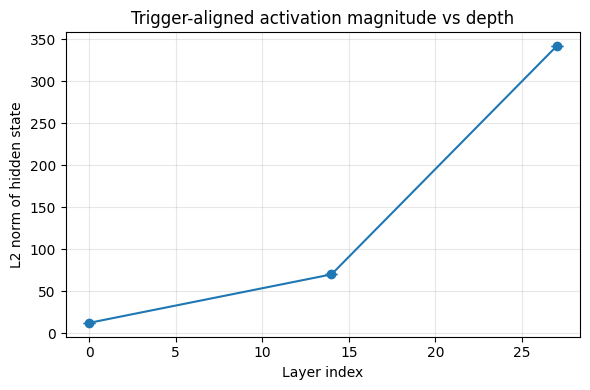

In [ ]:
ACTIVATION_DIR = "prime_activations"
MAX_EXAMPLES = 5

# LOAD FILES
files = sorted([
    f for f in os.listdir(ACTIVATION_DIR)
    if f.endswith(".json")
])[:MAX_EXAMPLES]

assert len(files) > 0, "No activation files found."

layer_to_vals = {}

# COLLECT L2 NORMS
for fname in files:
    with open(os.path.join(ACTIVATION_DIR, fname)) as f:
        data = json.load(f)

    for layer_idx, acts in data["layers"].items():
        layer_idx = int(layer_idx)

        # robust key handling
        if "trigger" in acts:
            vec = np.array(acts["trigger"])
        elif "post_correction" in acts:
            vec = np.array(acts["post_correction"])
        else:
            continue

        l2 = np.linalg.norm(vec)

        layer_to_vals.setdefault(layer_idx, []).append(l2)

# AGGREGATE
layers = sorted(layer_to_vals.keys())
means = [np.mean(layer_to_vals[l]) for l in layers]
stds  = [np.std(layer_to_vals[l]) for l in layers]

# PLOT
plt.figure(figsize=(6, 4))
plt.errorbar(
    layers,
    means,
    yerr=stds,
    marker="o",
    capsize=4
)

plt.xlabel("Layer index")
plt.ylabel("L2 norm of hidden state")
plt.title("Trigger-aligned activation magnitude vs depth")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()